# Exploratory Data Analysis of Aircraft Accidents Dataset

## Introduction

This Jupyter Notebook performs an exploratory data analysis on the aircraft accident dataset from PlaneCrashInfo.com. The dataset contains historical records of aviation accidents from 1920 to 2025, providing insights into accident frequency, fatalities, and geographical patterns. Our goal is to analyze the data to investigate potential impacts of climate change on aircraft accidents, focusing on temporal (yearly, monthly, seasonal) and geographical (country-based) trends.

## Dataset Description

The dataset, stored as aircraft_accidents.csv, includes the following columns:

Date: Date of the accident (e.g., "17-Sep-08").
Location / Operator: Combined location and operator (e.g., "Fort Myer, Virginia\nMilitary - U.S. Army").
Aircraft Type / Registration: Aircraft type and registration (e.g., "Wright Flyer III\n?").
Fatalities: Fatalities, total occupants, and ground fatalities in the format "X/Y(Z)" (e.g., "1/2(0)").

The dataset spans from 1908 (early aviation) to 2025, covering military, commercial, and private flights. It lacks direct weather or cause data, so we’ll use proxies like seasonal patterns and geographical hotspots to infer climate change effects.

## Objectives

* Preprocess the Data: Fix date parsing (correcting years like 2046 → 1946), split Location / Operator, extract country (mapping US states to "USA", USSR to "Russia"), and derive Year, Month, Season.

* Analyze Temporal Trends: Examine accidents by year, month, and season to detect weather-related patterns (e.g., summer storms, winter turbulence).

* Analyze Geographical Trends: Identify accident and fatalities hotspots by country.

* Investigate 1988 Airspace regulation impact: Assess if post-1988 accidents decrease.

* Investigate which aircraft manufacturer rendered highest no. of accidents and fatalities 

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

# Preprocessing of the Dataset

In [22]:
df = pd.read_csv('/kaggle/input/aircraft-accidents/aircraft_acidents.csv')
air_accident_df = pd.DataFrame(df)
air_accident_df

,Date,Location / Operator,Aircraft Type / Registration,Fatalities
0,17-Sep-08,"Fort Myer, Virginia\nMilitary - U.S. Army",Wright Flyer III\n?,1/2(0)
1,7-Sep-09,"Juvisy-sur-Orge, France\n?",Wright Byplane\nSC1,1/1(0)
2,12-Jul-12,"Atlantic City, New Jersey\nMilitary - U.S. Navy",Dirigible\n?,5/5(0)
3,6-Aug-13,"Victoria, British Columbia, Canada\nPrivate",Curtiss seaplane\n?,1/1(0)
4,9-Sep-13,Over the North Sea\nMilitary - German Navy,Zeppelin L-1 (airship)\n?,14/20(0)
...,...,...,...,...
5055,31-Jan-25,"Philadelphia, Pennsylvania\nMed Jets SA",Learjet 55\nXA-UCI,6/6(1)
5056,6-Feb-25,Norton Sound\nBering Air,Cessna 208B Grand Caravan\nN32BA,10/10(0)
5057,17-Feb-25,"Toronto, Canada\nDelta Connection, Edeavor Air",Bombardier CRJ-900LR\nN932XJ,0/80(0)
5058,25-Feb-25,"Omdurman, Sudan\nMilitary - Sudan Air Force",Antonov An-26\n?,17/17(29)


In [23]:
# Convert Date column to datetime, handling invalid dates
air_accident_df['Date'] = pd.to_datetime(air_accident_df['Date'], format='%d-%b-%y', errors='coerce')

# Adjust years greater than 2025 by subtracting 100 years to correct for century
def adjust_year(date):
    if pd.notnull(date) and date.year > 2025:
        return date.replace(year=date.year - 100)
    return date

air_accident_df['Date'] = air_accident_df['Date'].apply(adjust_year)

# Function to determine season based on month
def assign_season(month_name):
    winter_months = ['December', 'January', 'February']
    spring_months = ['March', 'April', 'May']
    summer_months = ['June', 'July', 'August']
    
    if month_name in winter_months:
        return 'Winter'
    elif month_name in spring_months:
        return 'Spring'
    elif month_name in summer_months:
        return 'Summer'
    return 'Fall'

air_accident_df['Month'] = air_accident_df['Date'].dt.month_name()
air_accident_df['Season'] = air_accident_df['Month'].apply(assign_season)
air_accident_df['Year'] = air_accident_df['Date'].dt.year
air_accident_df['Date'] = air_accident_df['Date'].dt.strftime('%B %d, %Y')

# Extract Year and Decade
air_accident_df['Date'] = pd.to_datetime(air_accident_df['Date'], format='%B %d, %Y', errors='coerce')
air_accident_df['Year'] = air_accident_df['Date'].dt.year
air_accident_df['Decade'] = (air_accident_df['Year'] // 10) * 10

In [24]:
# Split Location / Operator into separate columns
air_accident_df[['Location', 'Airline/Op']] = air_accident_df['Location / Operator'].str.split('\n', expand=True)
air_accident_df = air_accident_df.drop('Location / Operator', axis=1)
air_accident_df

# Split Aircraft Type / Registration into separate columns
air_accident_df[['Aircraft Type', 'Registration']] = air_accident_df['Aircraft Type / Registration'].str.split('\n', expand=True)
air_accident_df = air_accident_df.drop('Aircraft Type / Registration', axis=1)
air_accident_df


def parse_fatalities(fat_str):
    try:
        fatalities, rest = fat_str.split('/')
        aboard, ground = rest.split('(')
        ground = ground.strip(')')
        return pd.Series({
            'Fatalities': int(fatalities),
            'Aboard': int(aboard),
            'Ground': int(ground)
        })
    except:
        return pd.Series({
            'Fatalities': np.nan,
            'Aboard': np.nan,
            'Ground': np.nan
        })

air_accident_df[['Fatality', 'Aboard', 'Ground']] = air_accident_df['Fatalities'].apply(parse_fatalities)
air_accident_df = air_accident_df.drop('Fatalities', axis=1)
air_accident_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Date,Month,Season,Year,Decade,Location,Airline/Op,Aircraft Type,Registration,Fatality,Aboard,Ground
0,2008-09-17,September,Fall,2008,2000,"Fort Myer, Virginia",Military - U.S. Army,Wright Flyer III,?,1.0,2.0,0.0
1,2009-09-07,September,Fall,2009,2000,"Juvisy-sur-Orge, France",?,Wright Byplane,SC1,1.0,1.0,0.0
2,2012-07-12,July,Summer,2012,2010,"Atlantic City, New Jersey",Military - U.S. Navy,Dirigible,?,5.0,5.0,0.0
3,2013-08-06,August,Summer,2013,2010,"Victoria, British Columbia, Canada",Private,Curtiss seaplane,?,1.0,1.0,0.0
4,2013-09-09,September,Fall,2013,2010,Over the North Sea,Military - German Navy,Zeppelin L-1 (airship),?,14.0,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5055,2025-01-31,January,Winter,2025,2020,"Philadelphia, Pennsylvania",Med Jets SA,Learjet 55,XA-UCI,6.0,6.0,1.0
5056,2025-02-06,February,Winter,2025,2020,Norton Sound,Bering Air,Cessna 208B Grand Caravan,N32BA,10.0,10.0,0.0
5057,2025-02-17,February,Winter,2025,2020,"Toronto, Canada","Delta Connection, Edeavor Air",Bombardier CRJ-900LR,N932XJ,0.0,80.0,0.0
5058,2025-02-25,February,Winter,2025,2020,"Omdurman, Sudan",Military - Sudan Air Force,Antonov An-26,?,17.0,17.0,29.0


In [25]:
original_rows = len(air_accident_df)
print("original df rows: ", original_rows)
air_accident_df_cleaned = air_accident_df[~air_accident_df.eq('?').any(axis=1)]
air_accident_df_cleaned = air_accident_df_cleaned.dropna()
air_accident_df_cleaned.head(10)
air_accident_df = air_accident_df_cleaned
print("Cleaned df rows: ", len(air_accident_df))

original df rows:  5060
Cleaned df rows:  4743


In [26]:
air_accident_df

,Date,Month,Season,Year,Decade,Location,Airline/Op,Aircraft Type,Registration,Fatality,Aboard,Ground
23,2018-12-16,December,Winter,2018,2010,"Elizabeth, New Jersey",US Aerial Mail Service,De Havilland DH-4,97,1.0,1.0,0.0
24,2019-05-25,May,Spring,2019,2010,"Cleveland, Ohio",US Aerial Mail Service,De Havilland DH-4,61,1.0,1.0,0.0
25,2019-07-19,July,Summer,2019,2010,"Dix Run, Pennsylvania",US Aerial Mail Service,De Havilland DH-4,82,1.0,1.0,0.0
29,2019-10-14,October,Fall,2019,2010,"Cantonsville, Maryland",US Aerial Mail Service,Curtiss R-4LM,32,1.0,1.0,0.0
30,2019-10-20,October,Fall,2019,2010,"English Channel off Forkstone, Kent",Aircraft Transport and Travel,De Havilland DH-4,G-EAHG,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5053,2025-01-29,January,Winter,2025,2020,Washington DC,American Eagle / US Army,Canadair CRJ-701ER /UH-60 helicopter,N709PS /?,67.0,67.0,0.0
5054,2025-01-29,January,Winter,2025,2020,"GPOC Unity Airstrip, South Sudan",Light Air Services/Eagle Air,Beechcraft 1900D,5X-RHB,20.0,21.0,0.0
5055,2025-01-31,January,Winter,2025,2020,"Philadelphia, Pennsylvania",Med Jets SA,Learjet 55,XA-UCI,6.0,6.0,1.0
5056,2025-02-06,February,Winter,2025,2020,Norton Sound,Bering Air,Cessna 208B Grand Caravan,N32BA,10.0,10.0,0.0


In [27]:

us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
    'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
    'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
    'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

canada_provinces_cities = [
    'Alberta', 'British Columbia', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador',
    'Nova Scotia', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan',
    'Northwest Territories', 'Nunavut', 'Yukon',
    'Toronto', 'Montreal', 'Vancouver', 'Calgary', 'Edmonton', 'Ottawa', 'Winnipeg',
    'Quebec City', 'Halifax', 'Regina', 'Saskatoon', 'St. John\'s', 'Charlottetown',
    'Yellowknife', 'Iqaluit', 'Whitehorse'
]

# handle country cases 
def extract_country(location):
    if pd.isna(location):
        return 'Unknown'
    parts = location.split(',')
    country = parts[-1].strip()
    if country in ['North Sea', 'Mediterranean Sea', 'Atlantic Ocean', 'English Channel']:
        return 'International Waters'
    if country in ['England', 'Scotland', 'Wales']:
        return 'United Kingdom'
    if country == 'USSR':
        return 'Russia'  # Simplified for modern context
    if country in us_states:
        return 'USA'  
    if country in canada_provinces_cities:
        return 'Canada'  
    return country

air_accident_df['Country'] = air_accident_df['Location'].apply(extract_country)


In [28]:
# Function to classify operator type based on Airline/Op string
def categorize_operator(op):
    if pd.isna(op):
        return 'Unknown'
    op = op.lower()
    if 'military' in op:
        return 'Military'
    elif 'private' in op:
        return 'Private'
    else:
        return 'Commercial'

air_accident_df['Operator_Type'] = air_accident_df['Airline/Op'].apply(categorize_operator)
air_accident_df

,Date,Month,Season,Year,Decade,Location,Airline/Op,Aircraft Type,Registration,Fatality,Aboard,Ground,Country,Operator_Type
23,2018-12-16,December,Winter,2018,2010,"Elizabeth, New Jersey",US Aerial Mail Service,De Havilland DH-4,97,1.0,1.0,0.0,USA,Commercial
24,2019-05-25,May,Spring,2019,2010,"Cleveland, Ohio",US Aerial Mail Service,De Havilland DH-4,61,1.0,1.0,0.0,USA,Commercial
25,2019-07-19,July,Summer,2019,2010,"Dix Run, Pennsylvania",US Aerial Mail Service,De Havilland DH-4,82,1.0,1.0,0.0,USA,Commercial
29,2019-10-14,October,Fall,2019,2010,"Cantonsville, Maryland",US Aerial Mail Service,Curtiss R-4LM,32,1.0,1.0,0.0,USA,Commercial
30,2019-10-20,October,Fall,2019,2010,"English Channel off Forkstone, Kent",Aircraft Transport and Travel,De Havilland DH-4,G-EAHG,0.0,0.0,0.0,Kent,Commercial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5053,2025-01-29,January,Winter,2025,2020,Washington DC,American Eagle / US Army,Canadair CRJ-701ER /UH-60 helicopter,N709PS /?,67.0,67.0,0.0,Washington DC,Commercial
5054,2025-01-29,January,Winter,2025,2020,"GPOC Unity Airstrip, South Sudan",Light Air Services/Eagle Air,Beechcraft 1900D,5X-RHB,20.0,21.0,0.0,South Sudan,Commercial
5055,2025-01-31,January,Winter,2025,2020,"Philadelphia, Pennsylvania",Med Jets SA,Learjet 55,XA-UCI,6.0,6.0,1.0,USA,Commercial
5056,2025-02-06,February,Winter,2025,2020,Norton Sound,Bering Air,Cessna 208B Grand Caravan,N32BA,10.0,10.0,0.0,Norton Sound,Commercial


# Temporal Aircraft Accidents and Fatilities (Year, Month, Season)

Text(-0.1, 1.1, 'b')

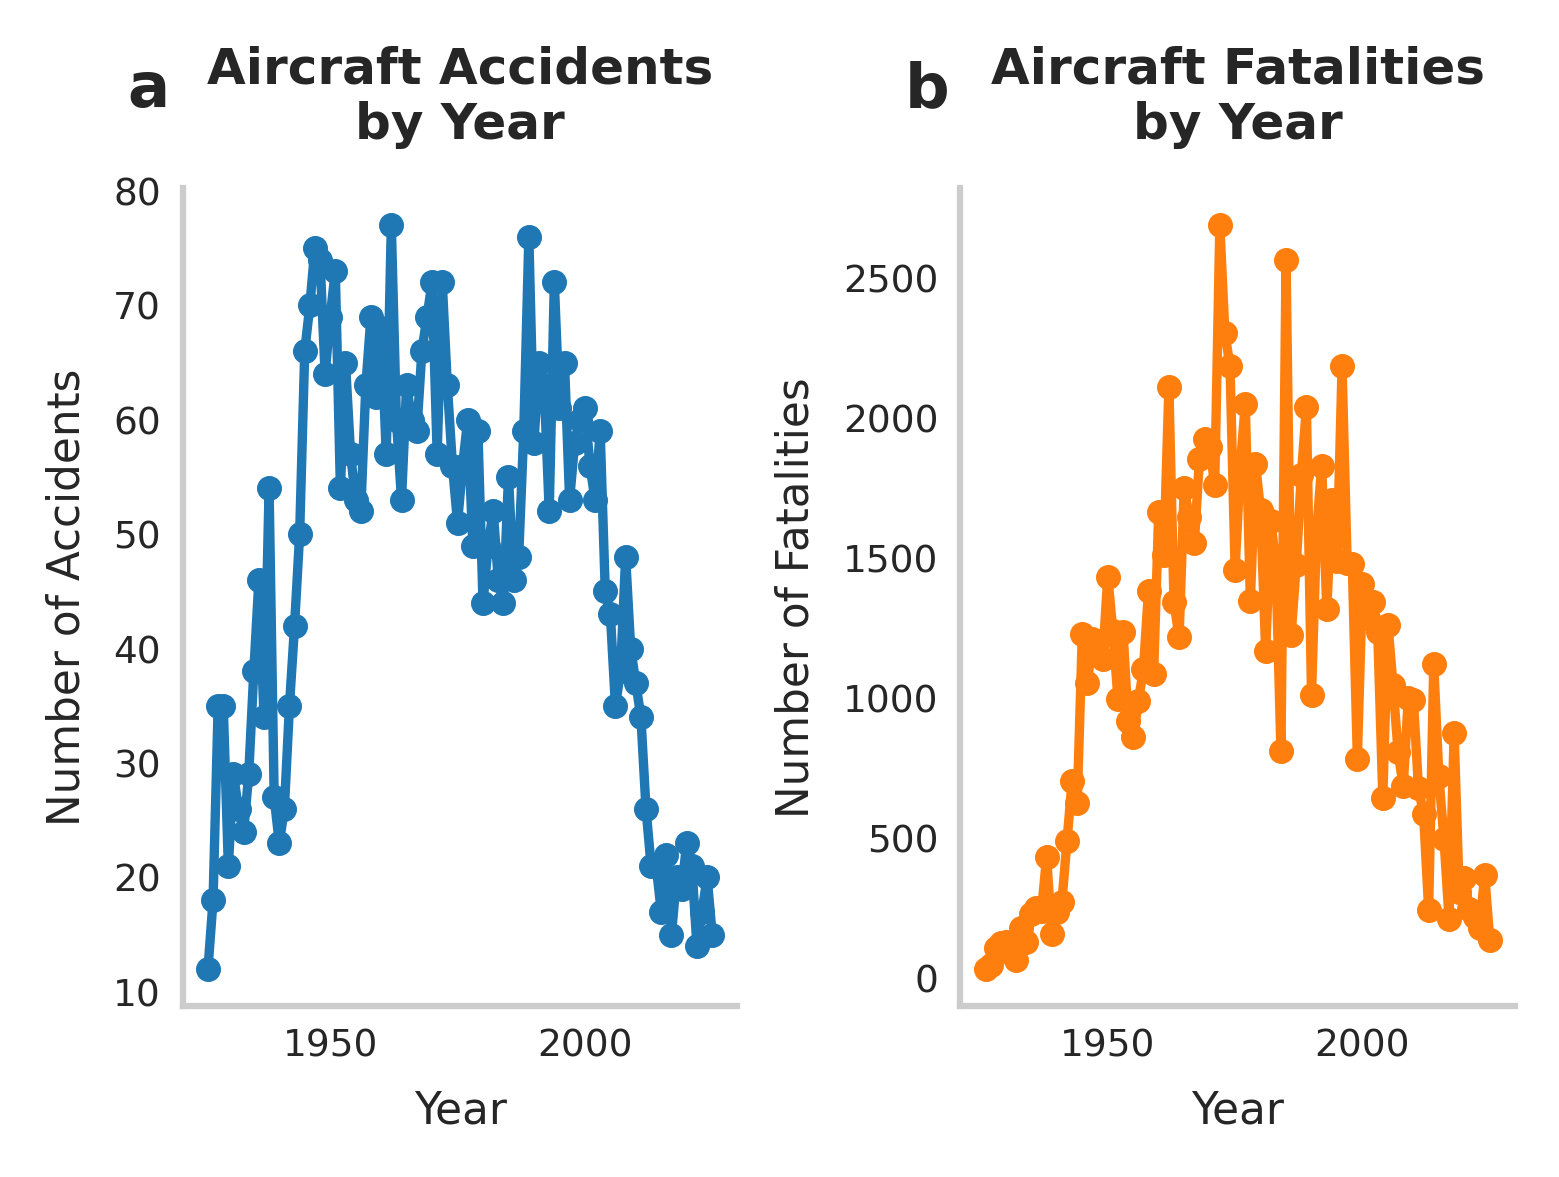

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8  

# Group by Year to calculate accidents and fatalities
yearly_data = air_accident_df.groupby('Year').agg({
    'Fatality': 'sum',  
    'Aboard': 'sum',
    'Date': 'count'
}).rename(columns={'Date': 'Accidents'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.35, 2.5), dpi=450, constrained_layout=True)

# Plot 1: Accidents by Year
ax1.plot(
    yearly_data.index, 
    yearly_data['Accidents'], 
    marker='o', 
    markersize=3, 
    linewidth=1.5, 
    color='#1f77b4'  
)
ax1.set_title('Aircraft Accidents\nby Year', fontsize=8, fontweight='bold', pad=8)
ax1.set_xlabel('Year', fontsize=7, fontweight='normal')
ax1.set_ylabel('Number of Accidents', fontsize=7, fontweight='normal')
ax1.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1)
ax1.spines['bottom'].set_linewidth(1)
ax1.grid(False)

# Plot 2: Fatalities by Year
ax2.plot(
    yearly_data.index, 
    yearly_data['Fatality'], 
    marker='o', 
    markersize=3, 
    linewidth=1.5, 
    color='#ff7f0e'  
)
ax2.set_title('Aircraft Fatalities\nby Year', fontsize=8, fontweight='bold', pad=8)
ax2.set_xlabel('Year', fontsize=7, fontweight='normal')
ax2.set_ylabel('Number of Fatalities', fontsize=7, fontweight='normal')
ax2.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1)
ax2.spines['bottom'].set_linewidth(1)
ax2.grid(False)

ax1.text(-0.1, 1.1, 'a', fontsize=10, fontweight='bold', transform=ax1.transAxes)
ax2.text(-0.1, 1.1, 'b', fontsize=10, fontweight='bold', transform=ax2.transAxes)

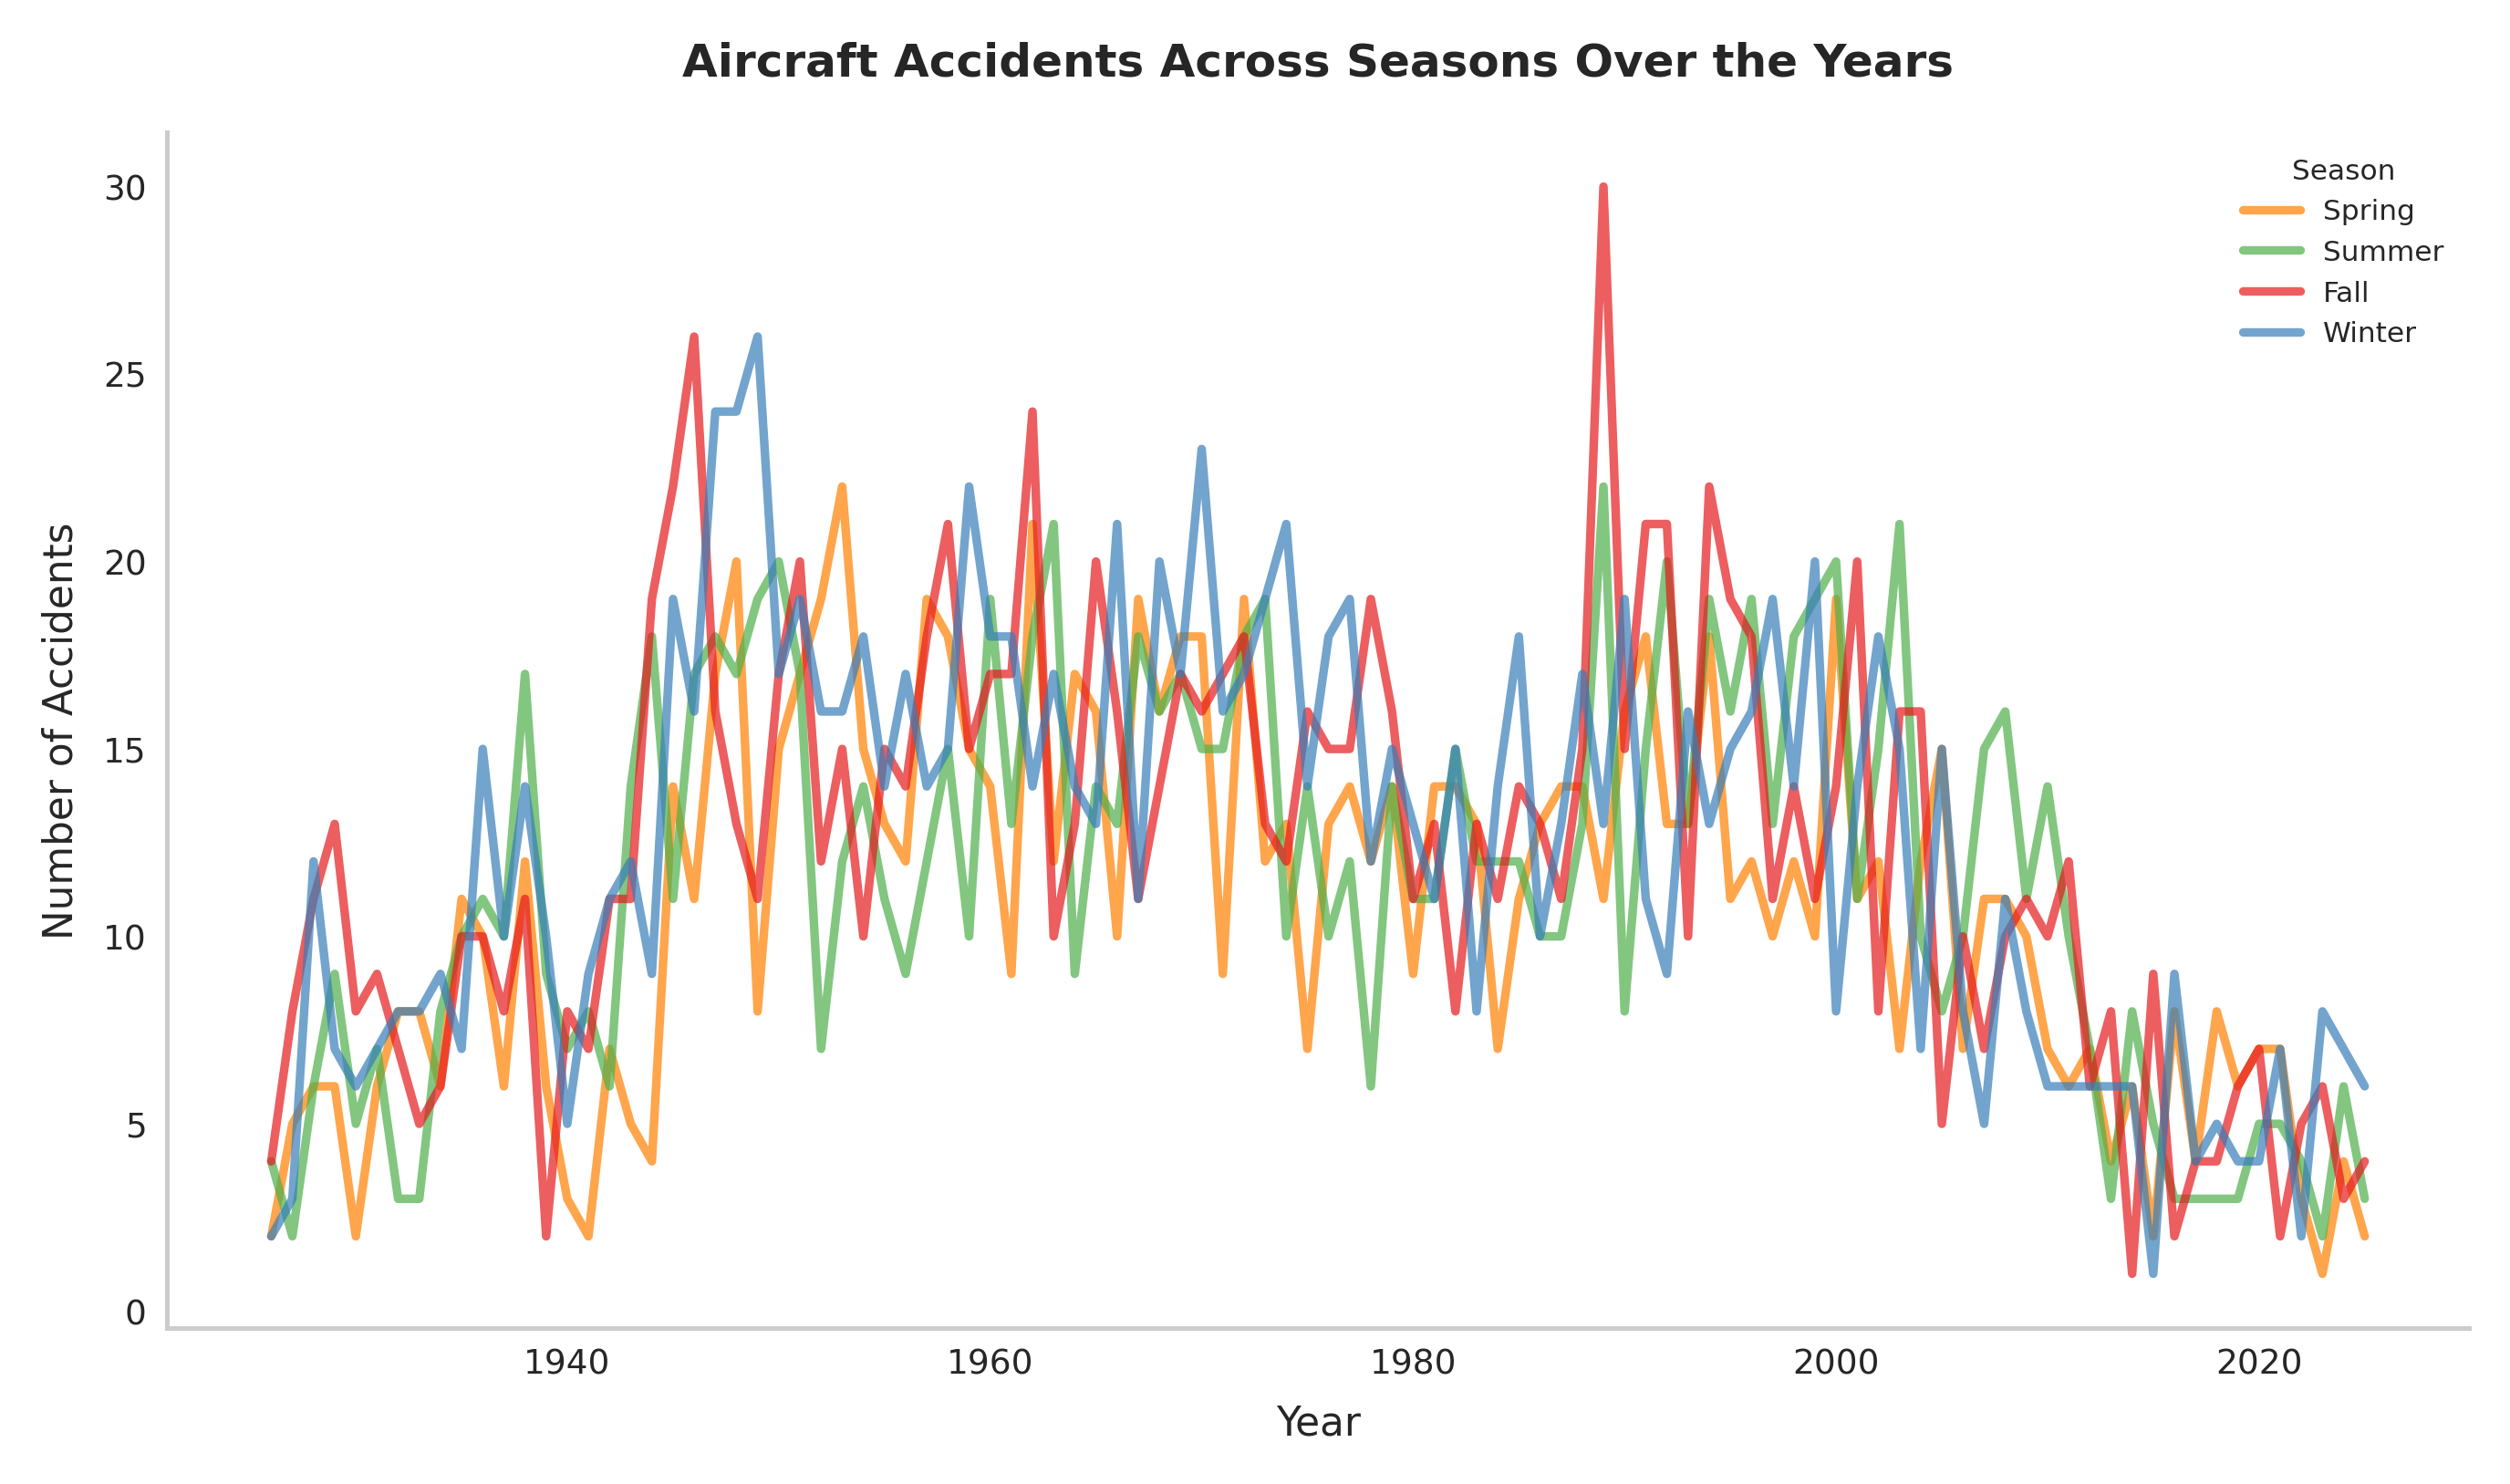

In [30]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8

seasonal_accidents = air_accident_df.groupby(['Year', 'Season']).size().unstack(fill_value=0)
season_totals = seasonal_accidents.sum().sort_values()
season_order = season_totals.index.tolist()  # Seasons ordered by total accidents
seasonal_accidents = seasonal_accidents[season_order]

fig, ax = plt.subplots(figsize=(6.0, 3.5), dpi=450, constrained_layout=True)
season_colors = {
    'Winter': '#377eb8',  
    'Spring': '#ff7f00', 
    'Summer': '#4daf4a',  
    'Fall': '#e41a1c'     
}

for season in season_order:
    ax.plot(seasonal_accidents.index, seasonal_accidents[season], 
            label=season, color=season_colors[season], linewidth=1.5, alpha=0.7)

ax.set_title('Aircraft Accidents Across Seasons Over the Years', fontsize=8, fontweight='bold', pad=10)
ax.set_xlabel('Year', fontsize=7)
ax.set_ylabel('Number of Accidents', fontsize=7)
ax.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.grid(True, linestyle='--', alpha=0.0)
ax.set_axisbelow(True)

ax.legend(title='Season', fontsize=5, title_fontsize=5, loc='upper right', frameon=False)
plt.show()

# Impact of 1988 Aviation Regulations on Accidents and Fatalities

/tmp/ipykernel_31/554374697.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(periods, fontsize=6, fontweight='normal', rotation=45, ha='right')
/tmp/ipykernel_31/554374697.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(periods, fontsize=6, fontweight='normal', rotation=45, ha='right')


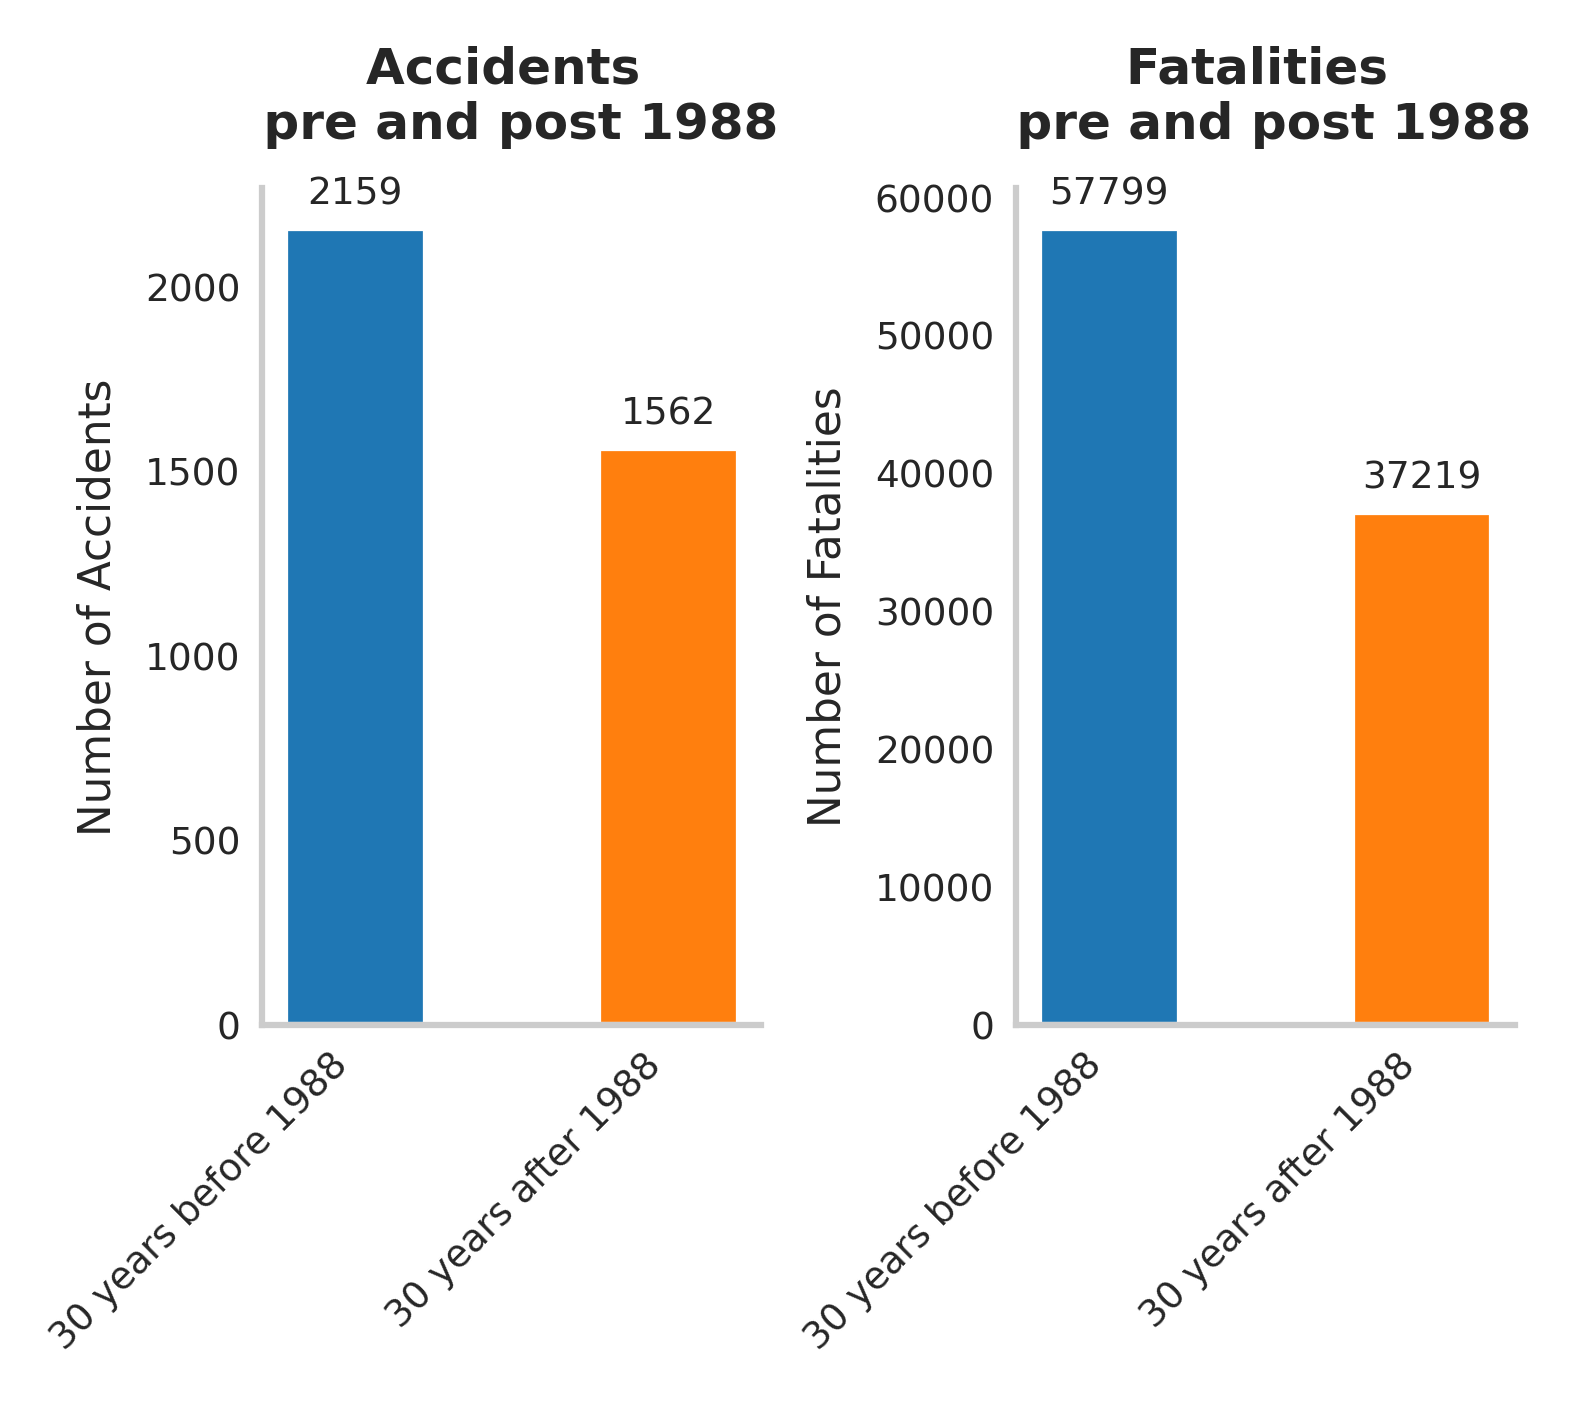

In [31]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8 

# Filter pre-1988 and post-1988
#1951 to 1988
pre_1988_df = air_accident_df[air_accident_df['Year'] >= 1951]
pre_1988_df = pre_1988_df[pre_1988_df['Year'] < 1988]
post_1988_df = air_accident_df[air_accident_df['Year'] >= 1988]

pre_1988_accidents = len(pre_1988_df)
post_1988_accidents = len(post_1988_df)

pre_1988_fatalities = pre_1988_df['Fatality'].sum()
post_1988_fatalities = post_1988_df['Fatality'].sum()

periods = ['30 years before 1988', '30 years after 1988']
accident_counts = [pre_1988_accidents, post_1988_accidents]
fatality_counts = [pre_1988_fatalities, post_1988_fatalities]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.35, 3.0), dpi=450, sharey=False, constrained_layout=True)

# Plot 1: Accidents
bars1 = ax1.bar(periods, accident_counts, color=['#1f77b4', '#ff7f0e'], width=0.45, align='center')
ax1.set_title('Accidents \n pre and post 1988', fontsize=8, fontweight='bold', pad=8)

ax1.set_ylabel('Number of Accidents', fontsize=7, fontweight='normal')
ax1.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax1.set_xticklabels(periods, fontsize=6, fontweight='normal', rotation=45, ha='right')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_linewidth(1)
ax1.spines['bottom'].set_linewidth(1)
ax1.grid(False)

for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.02 * max(accident_counts), 
             int(yval), ha='center', va='bottom', fontsize=6)

# Plot 2: Fatalities
bars2 = ax2.bar(periods, fatality_counts, color=['#1f77b4', '#ff7f0e'], width=0.45, align='center')
ax2.set_title('Fatalities \n pre and post 1988', fontsize=8, fontweight='bold', pad=8)
ax2.set_ylabel('Number of Fatalities', fontsize=7, fontweight='normal')
ax2.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax2.set_xticklabels(periods, fontsize=6, fontweight='normal', rotation=45, ha='right')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1)
ax2.spines['bottom'].set_linewidth(1)
ax2.grid(False)

# Add value labels above bars for fatalities
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.02 * max(fatality_counts), 
             int(yval), ha='center', va='bottom', fontsize=6)


# Geographic Variations in Aircraft Accidents and Fatalities

Text(-0.1, 1.1, 'a')

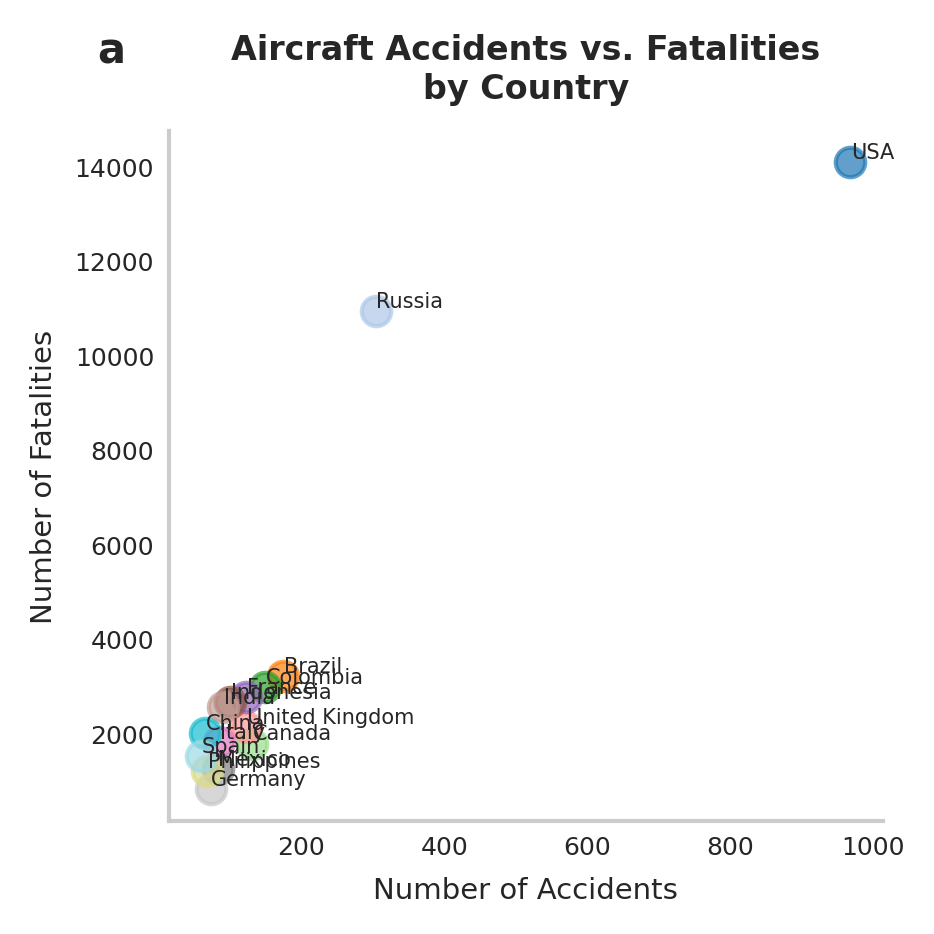

In [32]:
# Set font and size for the plot
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8

# Get the top 15 countries by number of accidents
top_countries = air_accident_df['Country'].value_counts().head(15).index
top_countries_df = air_accident_df[air_accident_df['Country'].isin(top_countries)]

# Calculate total accidents per country
accidents_by_country = top_countries_df.pivot_table(
    index='Country',
    values='Date',
    aggfunc='count',
    fill_value=0
)

# Calculate total fatalities per country
fatalities_by_country = top_countries_df.pivot_table(
    index='Country',
    values='Fatality',
    aggfunc='sum',
    fill_value=0
)

# Ensure countries are in the order of top_countries
accidents_by_country = accidents_by_country.loc[top_countries]
fatalities_by_country = fatalities_by_country.loc[top_countries]

fig, ax = plt.subplots(figsize=(3, 3), dpi=300, constrained_layout=True)
colors = plt.cm.tab20(np.linspace(0, 1, len(top_countries)))

for i, country in enumerate(top_countries):
    accidents = accidents_by_country.loc[country, 'Date']
    fatalities = fatalities_by_country.loc[country, 'Fatality']
    ax.scatter(accidents, fatalities, color=colors[i], s=50, alpha=0.7, label=country)
    ax.text(accidents + 1, fatalities + 1, country, fontsize=5, ha='left', va='bottom')

ax.set_title('Aircraft Accidents vs. Fatalities\nby Country', fontsize=8, fontweight='bold', pad=8)
ax.set_xlabel('Number of Accidents', fontsize=7, fontweight='normal')
ax.set_ylabel('Number of Fatalities', fontsize=7, fontweight='normal')
ax.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.grid(True, linestyle='--', alpha=0.0)
ax.text(-0.1, 1.1, 'a', fontsize=10, fontweight='bold', transform=ax.transAxes)



Text(-0.1, 1.1, 'a')

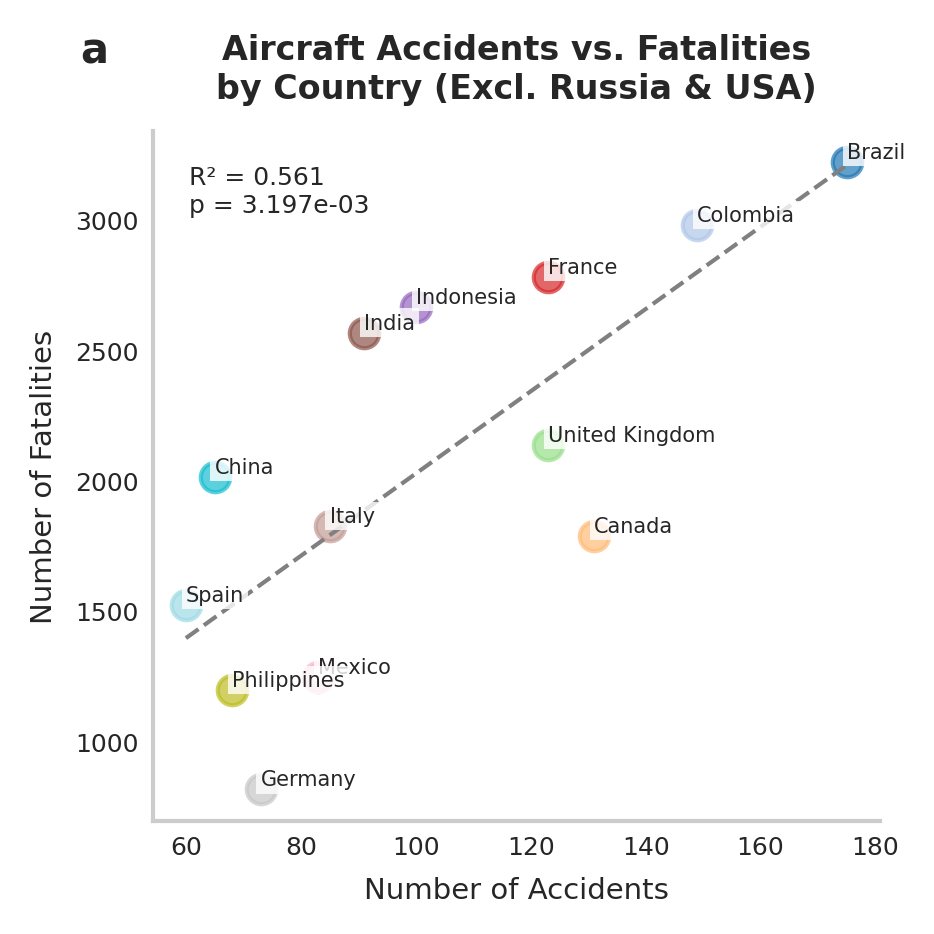

In [33]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Set font and size for the plot
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8

# Get the top 15 countries by number of accidents
top_countries = air_accident_df['Country'].value_counts().head(15).index
# Exclude Russia and USA
top_countries = [country for country in top_countries if country not in ['Russia', 'USA']]
top_countries_df = air_accident_df[air_accident_df['Country'].isin(top_countries)]

# Calculate total accidents per country
accidents_by_country = top_countries_df.pivot_table(
    index='Country',
    values='Date',
    aggfunc='count',
    fill_value=0
)

# Calculate total fatalities per country
fatalities_by_country = top_countries_df.pivot_table(
    index='Country',
    values='Fatality',
    aggfunc='sum',
    fill_value=0
)

accidents_by_country = accidents_by_country.loc[top_countries]
fatalities_by_country = fatalities_by_country.loc[top_countries]

x = accidents_by_country['Date'].values
y = fatalities_by_country['Fatality'].values
slope, intercept, r_value, p_value, _ = linregress(x, y)
r_squared = r_value**2

fig, ax = plt.subplots(figsize=(3, 3), dpi=300, constrained_layout=True)
colors = plt.cm.tab20(np.linspace(0, 1, len(top_countries)))

texts = []
for i, country in enumerate(top_countries):
    accidents = accidents_by_country.loc[country, 'Date']
    fatalities = fatalities_by_country.loc[country, 'Fatality']
    ax.scatter(accidents, fatalities, color=colors[i], s=50, alpha=0.7, label=country)
    # Add country name label with a white background
    text = ax.text(accidents, fatalities, country, fontsize=5, ha='left', va='bottom',
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1))
    texts.append(text)

x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='gray', linestyle='--', linewidth=1, label='Fit')
ax.text(0.05, 0.95, f'R² = {r_squared:.3f}\np = {p_value:.3e}',
        fontsize=6, transform=ax.transAxes, va='top')
ax.set_title('Aircraft Accidents vs. Fatalities\nby Country (Excl. Russia & USA)',
             fontsize=8, fontweight='bold', pad=8)
ax.set_xlabel('Number of Accidents', fontsize=7, fontweight='normal')
ax.set_ylabel('Number of Fatalities', fontsize=7, fontweight='normal')
ax.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.grid(True, linestyle='--', alpha=0.0)
ax.text(-0.1, 1.1, 'a', fontsize=10, fontweight='bold', transform=ax.transAxes)

# Aircraft Accidents and Fatalities by Aircraft Type

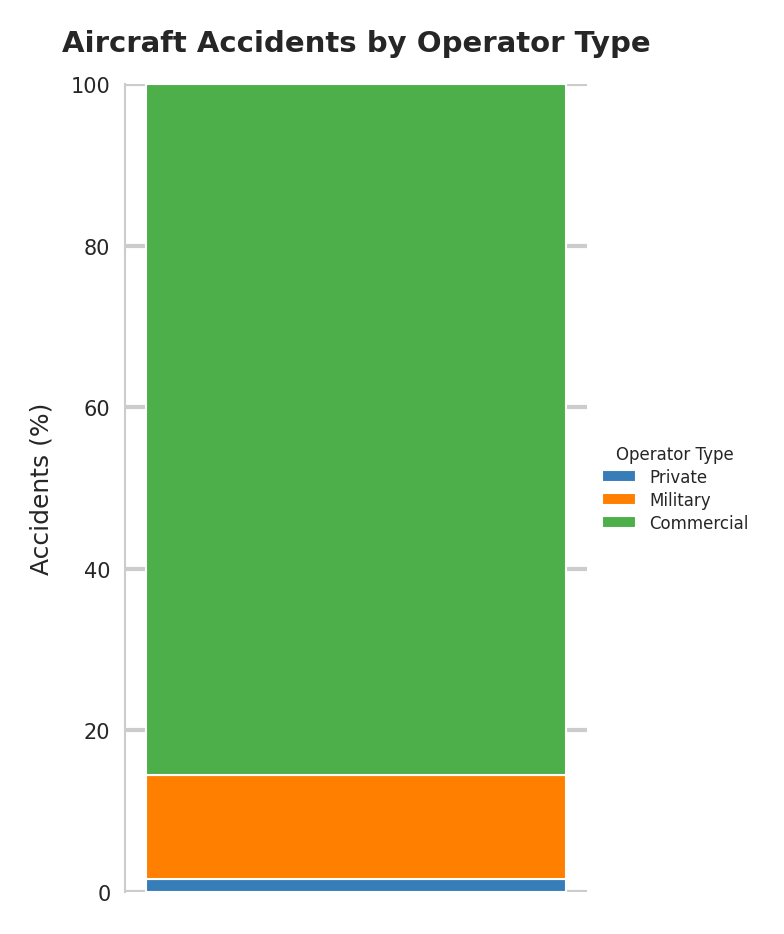

In [34]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7

operator_counts = air_accident_df['Airline/Op'].apply(lambda x: 'Military' if 'Military' in str(x) else ('Private' if 'Private' in str(x) else 'Commercial')).value_counts()
operator_types = ['Private', 'Military', 'Commercial']
operator_counts = operator_counts.reindex(operator_types, fill_value=0)
total_accidents = operator_counts.sum()
operator_percentages = (operator_counts / total_accidents * 100).round(1)

fig, ax = plt.subplots(figsize=(2.5, 3.0), dpi=300, constrained_layout=True)
colors = ['#377eb8', '#ff7f00', '#4daf4a'] 

bottom = 0
for i, (operator, percentage) in enumerate(operator_percentages.items()):
    ax.bar('Operator Type', percentage, bottom=bottom, width=0.2, color=colors[i], label=operator, 
           edgecolor='white', linewidth=0.5)
    mid_point = bottom + percentage / 2
    bottom += percentage

ax.set_title('Aircraft Accidents by Operator Type', fontsize=7, fontweight='bold', pad=8)
ax.set_ylabel('Accidents (%)', fontsize=6)
ax.set_ylim(0, 100)  # Set y-axis from 0 to 100 for percentages
ax.set_xticks([]) 
ax.tick_params(axis='y', labelsize=5, direction='in', length=3, width=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['bottom'].set_visible(False)  # No need for bottom spine with single bar

ax.legend(title='Operator Type', fontsize=4, title_fontsize=4, loc='center left', 
          bbox_to_anchor=(1, 0.5), frameon=False, labelspacing=0.3)
plt.show()

Text(-0.1, 1.1, 'b')

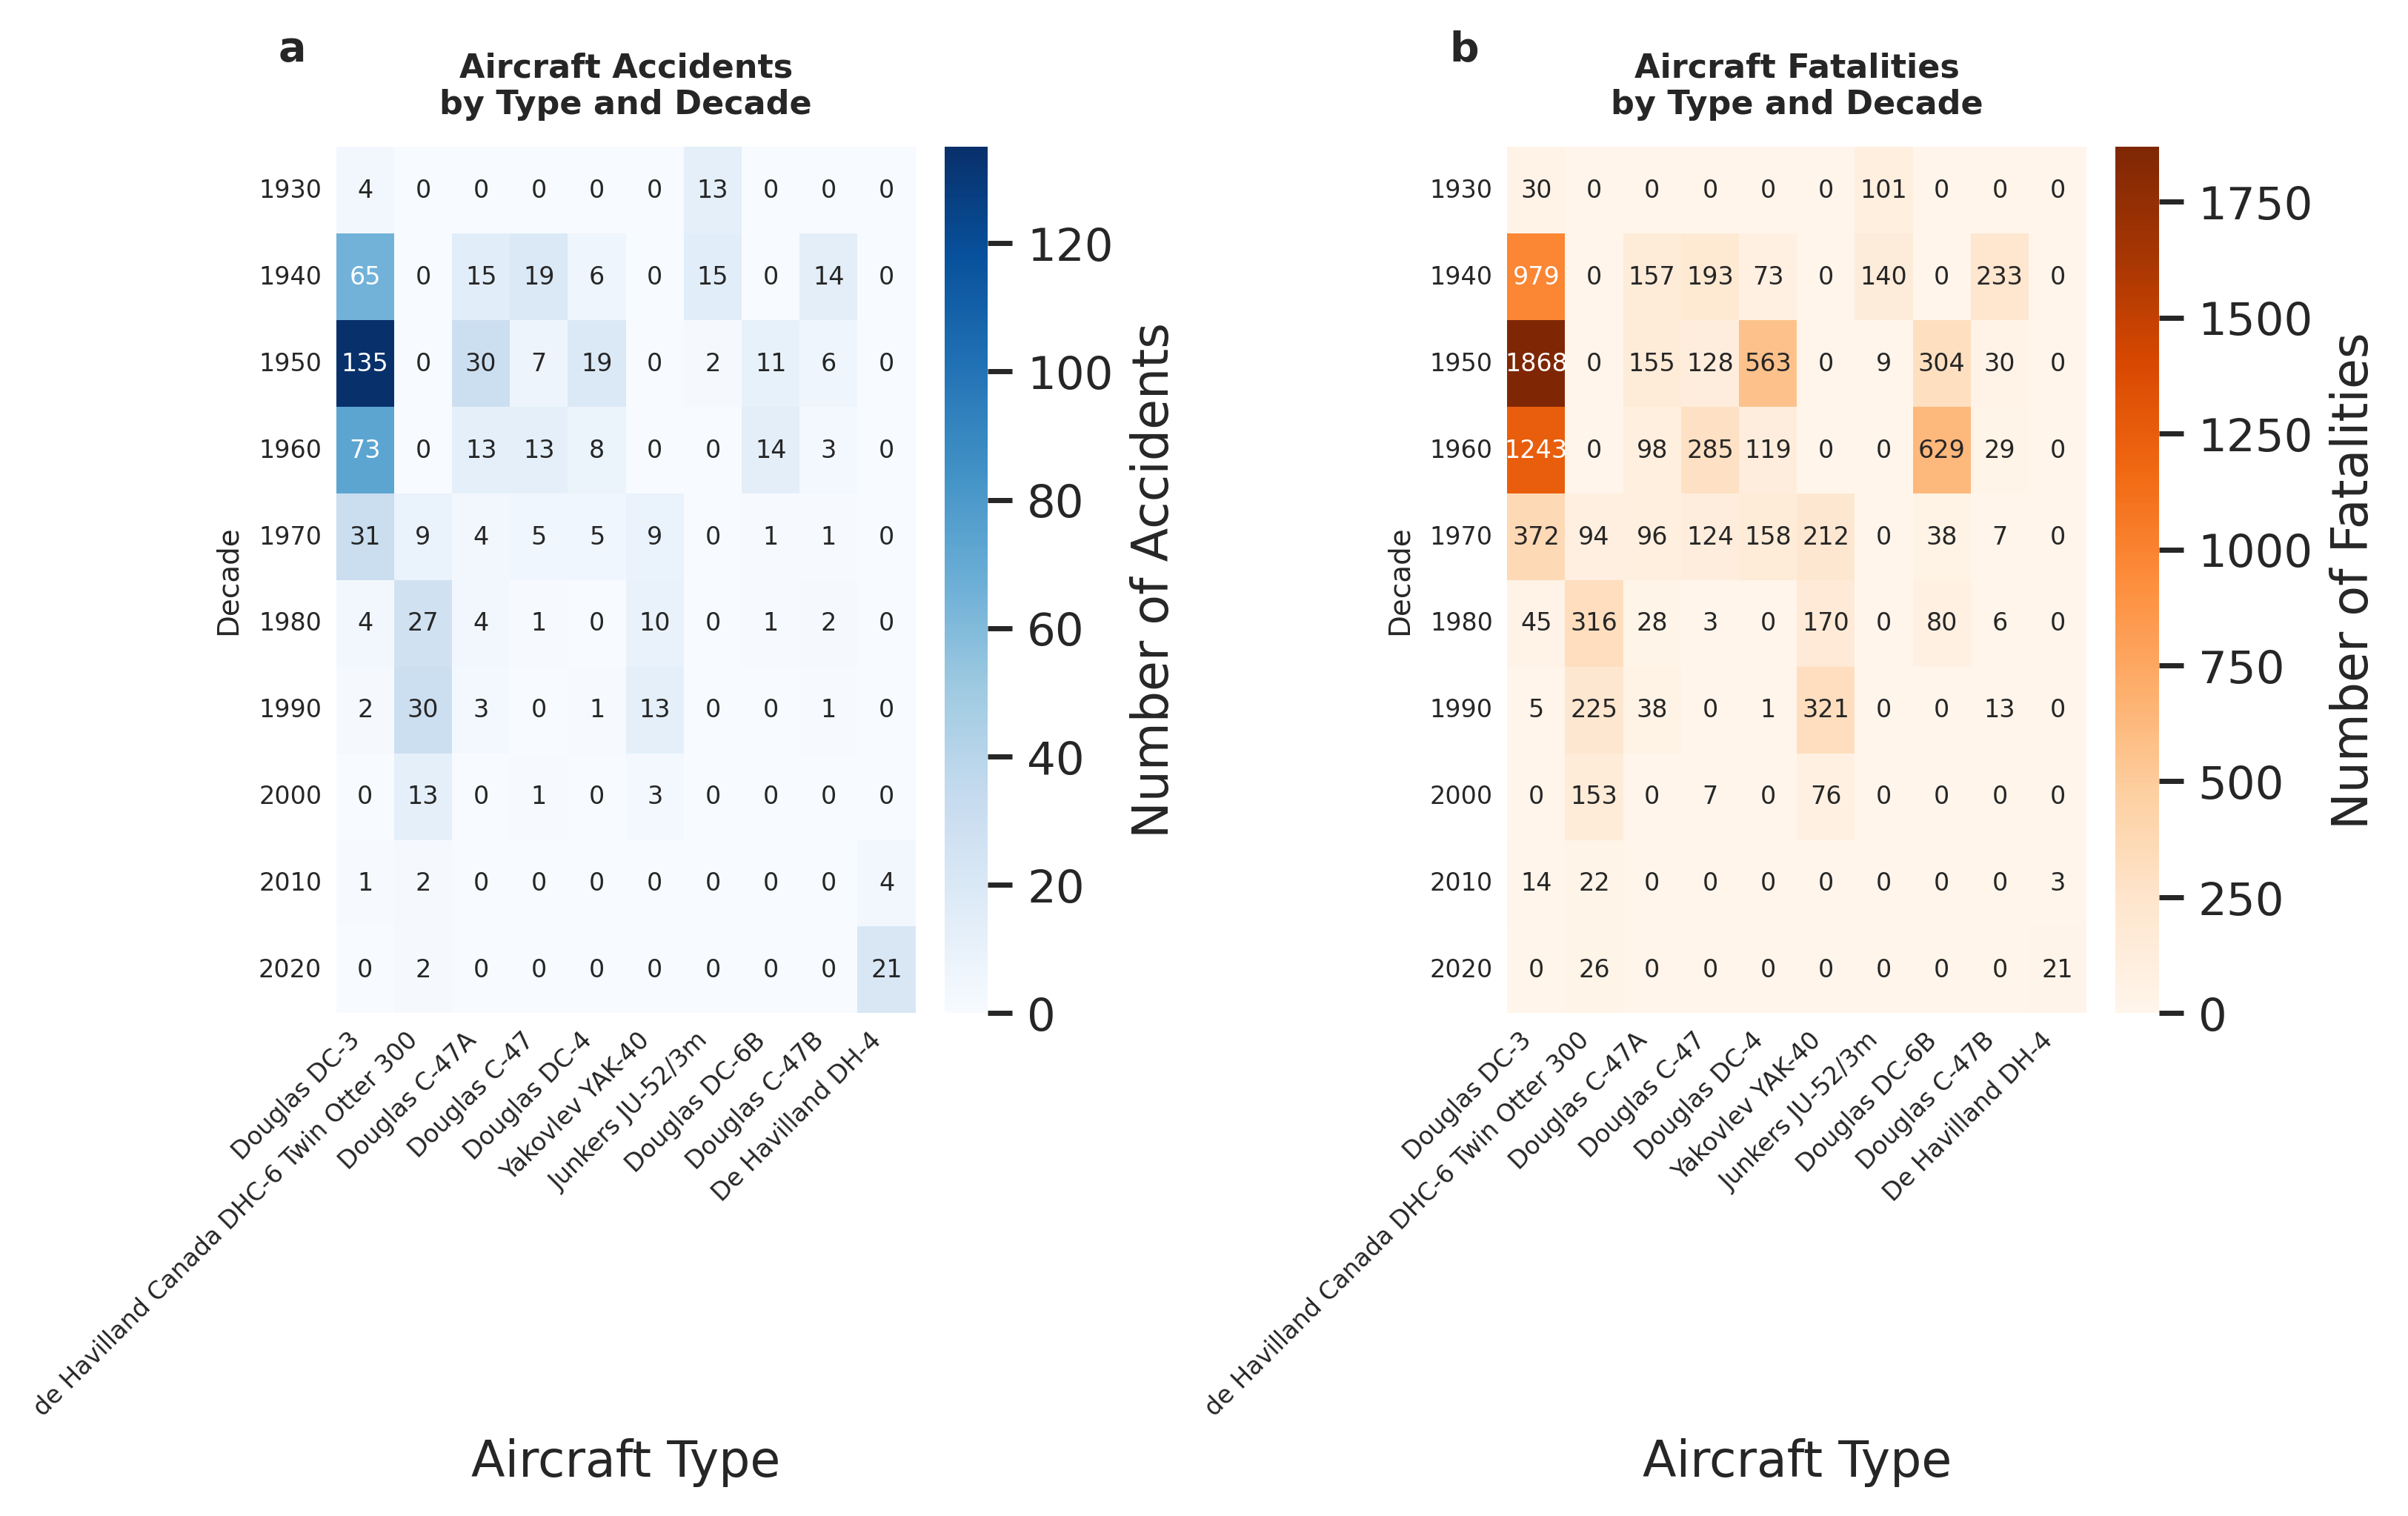

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8 

top_aircraft = air_accident_df['Aircraft Type'].value_counts().head(10).index
top_aircraft_df = air_accident_df[air_accident_df['Aircraft Type'].isin(top_aircraft)]

pivot_accidents = top_aircraft_df.pivot_table(
    index='Decade', 
    columns='Aircraft Type', 
    values='Date', 
    aggfunc='count', 
    fill_value=0
)

pivot_fatalities = top_aircraft_df.pivot_table(
    index='Decade', 
    columns='Aircraft Type', 
    values='Fatality', 
    aggfunc='sum', 
    fill_value=0
)

pivot_accidents = pivot_accidents[top_aircraft]
pivot_fatalities = pivot_fatalities[top_aircraft]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5), dpi=400, constrained_layout=True)

# Plot 1: Heatmap for Accidents
sns.heatmap(
    pivot_accidents, 
    cmap='Blues', 
    annot=True, 
    fmt='g', 
    cbar_kws={'label': 'Number of Accidents'}, 
    ax=ax1, 
    annot_kws={'fontsize': 6, 'fontfamily': 'Arial'},
    cbar=True
)
ax1.set_title('Aircraft Accidents\nby Type and Decade', fontsize=8, fontweight='bold', pad=8)
ax1.set_ylabel('Decade', fontsize=7, fontweight='normal')
ax1.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=6)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=6)

# Plot 2: Heatmap for Fatalities
sns.heatmap(
    pivot_fatalities, 
    cmap='Oranges', 
    annot=True, 
    fmt='g', 
    cbar_kws={'label': 'Number of Fatalities'}, 
    ax=ax2, 
    annot_kws={'fontsize': 6, 'fontfamily': 'Arial'},
    cbar=True
)
ax2.set_title('Aircraft Fatalities\nby Type and Decade', fontsize=8, fontweight='bold', pad=8)
ax2.set_ylabel('Decade', fontsize=7, fontweight='normal')
ax2.tick_params(axis='both', which='major', labelsize=6, direction='in', length=4, width=1)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=6)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=6)

ax1.text(-0.1, 1.1, 'a', fontsize=10, fontweight='bold', transform=ax1.transAxes)
ax2.text(-0.1, 1.1, 'b', fontsize=10, fontweight='bold', transform=ax2.transAxes)

#  Airline Manufacturer Accidents and Fatalities

In [36]:
# Manufacturers are from the dataset
# Binning all the main manufacturers together under one label 
def map_manufacturer(ac_type):
    if pd.isna(ac_type):
        return 'Unknown'
    ac_type = ac_type.lower()
    if 'boeing' in ac_type:
        return 'Boeing'
    elif 'douglas' in ac_type or 'mcdonnell douglas' in ac_type:
        return 'Douglas/McDonnell Douglas'
    elif 'de havilland' in ac_type or 'dehavilland' in ac_type or 'dch' in ac_type or 'dhc' in ac_type:
        return 'De Havilland'
    elif 'curtiss' in ac_type:
        return 'Curtiss'
    elif 'zepplin' in ac_type or 'zeppelin' in ac_type or 'airship' in ac_type or 'dirigible' in ac_type or 'schutte-lanz' in ac_type or 'royal airship' in ac_type or 'goodyear' in ac_type:
        return 'Zeppelin/Airship'
    elif 'wright' in ac_type:
        return 'Wright'
    elif 'breguet' in ac_type:
        return 'Breguet'
    elif 'fokker' in ac_type:
        return 'Fokker'
    elif 'ford' in ac_type:
        return 'Ford'
    elif 'junkers' in ac_type:
        return 'Junkers'
    elif 'latecoere' in ac_type or 'latécoère' in ac_type:
        return 'Latecoere'
    elif 'farman' in ac_type:
        return 'Farman'
    elif 'lockheed' in ac_type:
        return 'Lockheed'
    elif 'travel air' in ac_type:
        return 'Travel Air'
    elif 'fairchild' in ac_type:
        return 'Fairchild'
    elif 'stinson' in ac_type:
        return 'Stinson'
    elif 'pitcairn' in ac_type:
        return 'Pitcairn'
    elif 'dornier' in ac_type:
        return 'Dornier'
    elif 'bleriot' in ac_type or 'blériot' in ac_type:
        return 'Bleriot'
    elif 'handley page' in ac_type:
        return 'Handley Page'
    elif 'avro' in ac_type:
        return 'Avro'
    elif 'potez' in ac_type:
        return 'Potez'
    elif 'sikorsky' in ac_type:
        return 'Sikorsky'
    elif 'stearman' in ac_type:
        return 'Stearman'
    elif 'lvg' in ac_type:
        return 'LVG'
    elif 'liore' in ac_type or 'lioré' in ac_type:
        return 'Liore et Olivier'
    elif 'savoia' in ac_type:
        return 'Savoia Marchetti'
    elif 'short' in ac_type:
        return 'Short'
    elif 'loening' in ac_type:
        return 'Loening'
    elif 'kalinin' in ac_type:
        return 'Kalinin'
    elif 'arado' in ac_type:
        return 'Arado'
    elif 'messerschmitt' in ac_type:
        return 'Messerschmitt'
    elif 'heinkel' in ac_type:
        return 'Heinkel'
    elif 'desoutter' in ac_type:
        return 'Desoutter'
    elif 'lasco' in ac_type:
        return 'Lasco'
    elif 'salmson' in ac_type:
        return 'Salmson'
    elif 'armstrong-whitworth' in ac_type or 'armstrong whitworth' in ac_type:
        return 'Armstrong-Whitworth'
    elif 'caproni' in ac_type:
        return 'Caproni'
    elif 'aeromarine' in ac_type:
        return 'Aeromarine'
    elif 'vickers' in ac_type:
        return 'Vickers'
    elif 'spca' in ac_type:
        return 'SPCA'
    elif 'aegk' in ac_type:
        return 'AEGK'
    elif 'rohrbach' in ac_type:
        return 'Rohrbach'
    elif 'caudron' in ac_type:
        return 'Caudron'
    elif 'sabca' in ac_type:
        return 'Sabca'
    elif 'cams' in ac_type:
        return 'CAMS'
    elif 'cmasa' in ac_type:
        return 'CMASA'
    # Additional common manufacturers in aviation
    elif 'airbus' in ac_type:
        return 'Airbus'
    elif 'antonov' in ac_type:
        return 'Antonov'
    elif 'atr' in ac_type:
        return 'ATR'
    elif 'bell' in ac_type:
        return 'Bell'
    elif 'beechcraft' in ac_type or 'beech' in ac_type:
        return 'Beechcraft'
    elif 'britten-norman' in ac_type or 'britten norman' in ac_type:
        return 'Britten-Norman'
    elif 'canadair' in ac_type:
        return 'Canadair'
    elif 'cessna' in ac_type:
        return 'Cessna'
    elif 'convair' in ac_type:
        return 'Convair'
    elif 'embraer' in ac_type:
        return 'Embraer'
    elif 'eurocopter' in ac_type or 'aerospatiale' in ac_type:
        return 'Eurocopter/Aerospatiale'
    elif 'hawker' in ac_type:
        return 'Hawker'
    elif 'ilyushin' in ac_type:
        return 'Ilyushin'
    elif 'learjet' in ac_type:
        return 'Learjet'
    elif 'let' in ac_type:
        return 'Let'
    elif 'mil' in ac_type or 'mi-' in ac_type:
        return 'Mil'
    elif 'piper' in ac_type:
        return 'Piper'
    elif 'sukhoi' in ac_type:
        return 'Sukhoi'
    elif 'tupolev' in ac_type:
        return 'Tupolev'
    elif 'yakovlev' in ac_type or 'yak' in ac_type:
        return 'Yakovlev'
    elif 'north american' in ac_type:
        return 'North American'
    elif 'northrop' in ac_type:
        return 'Northrop'
    elif 'grumman' in ac_type:
        return 'Grumman'
    elif 'bombardier' in ac_type:
        return 'Bombardier'
    elif 'british aerospace' in ac_type or 'bae' in ac_type:
        return 'British Aerospace'
    elif 'saab' in ac_type:
        return 'Saab'
    elif 'sud aviation' in ac_type:
        return 'Sud Aviation'
    elif 'focke-wulf' in ac_type:
        return 'Focke-Wulf'
    elif 'shaanxi' in ac_type:
        return 'Shaanxi'
    elif 'pilatus' in ac_type:
        return 'Pilatus'
    elif 'pac' in ac_type or 'pacific aerospace' in ac_type:
        return 'Pacific Aerospace'
    elif 'hesa' in ac_type:
        return 'HESA'
    elif 'kubicek' in ac_type:
        return 'Kubicek'
    else:
        return 'Other'

air_accident_df['Manufacturer'] = air_accident_df['Aircraft Type'].apply(map_manufacturer)

(-1.0999999845924036,
 1.099999676515995,
 -1.0999999857390699,
 1.0999999919204047)

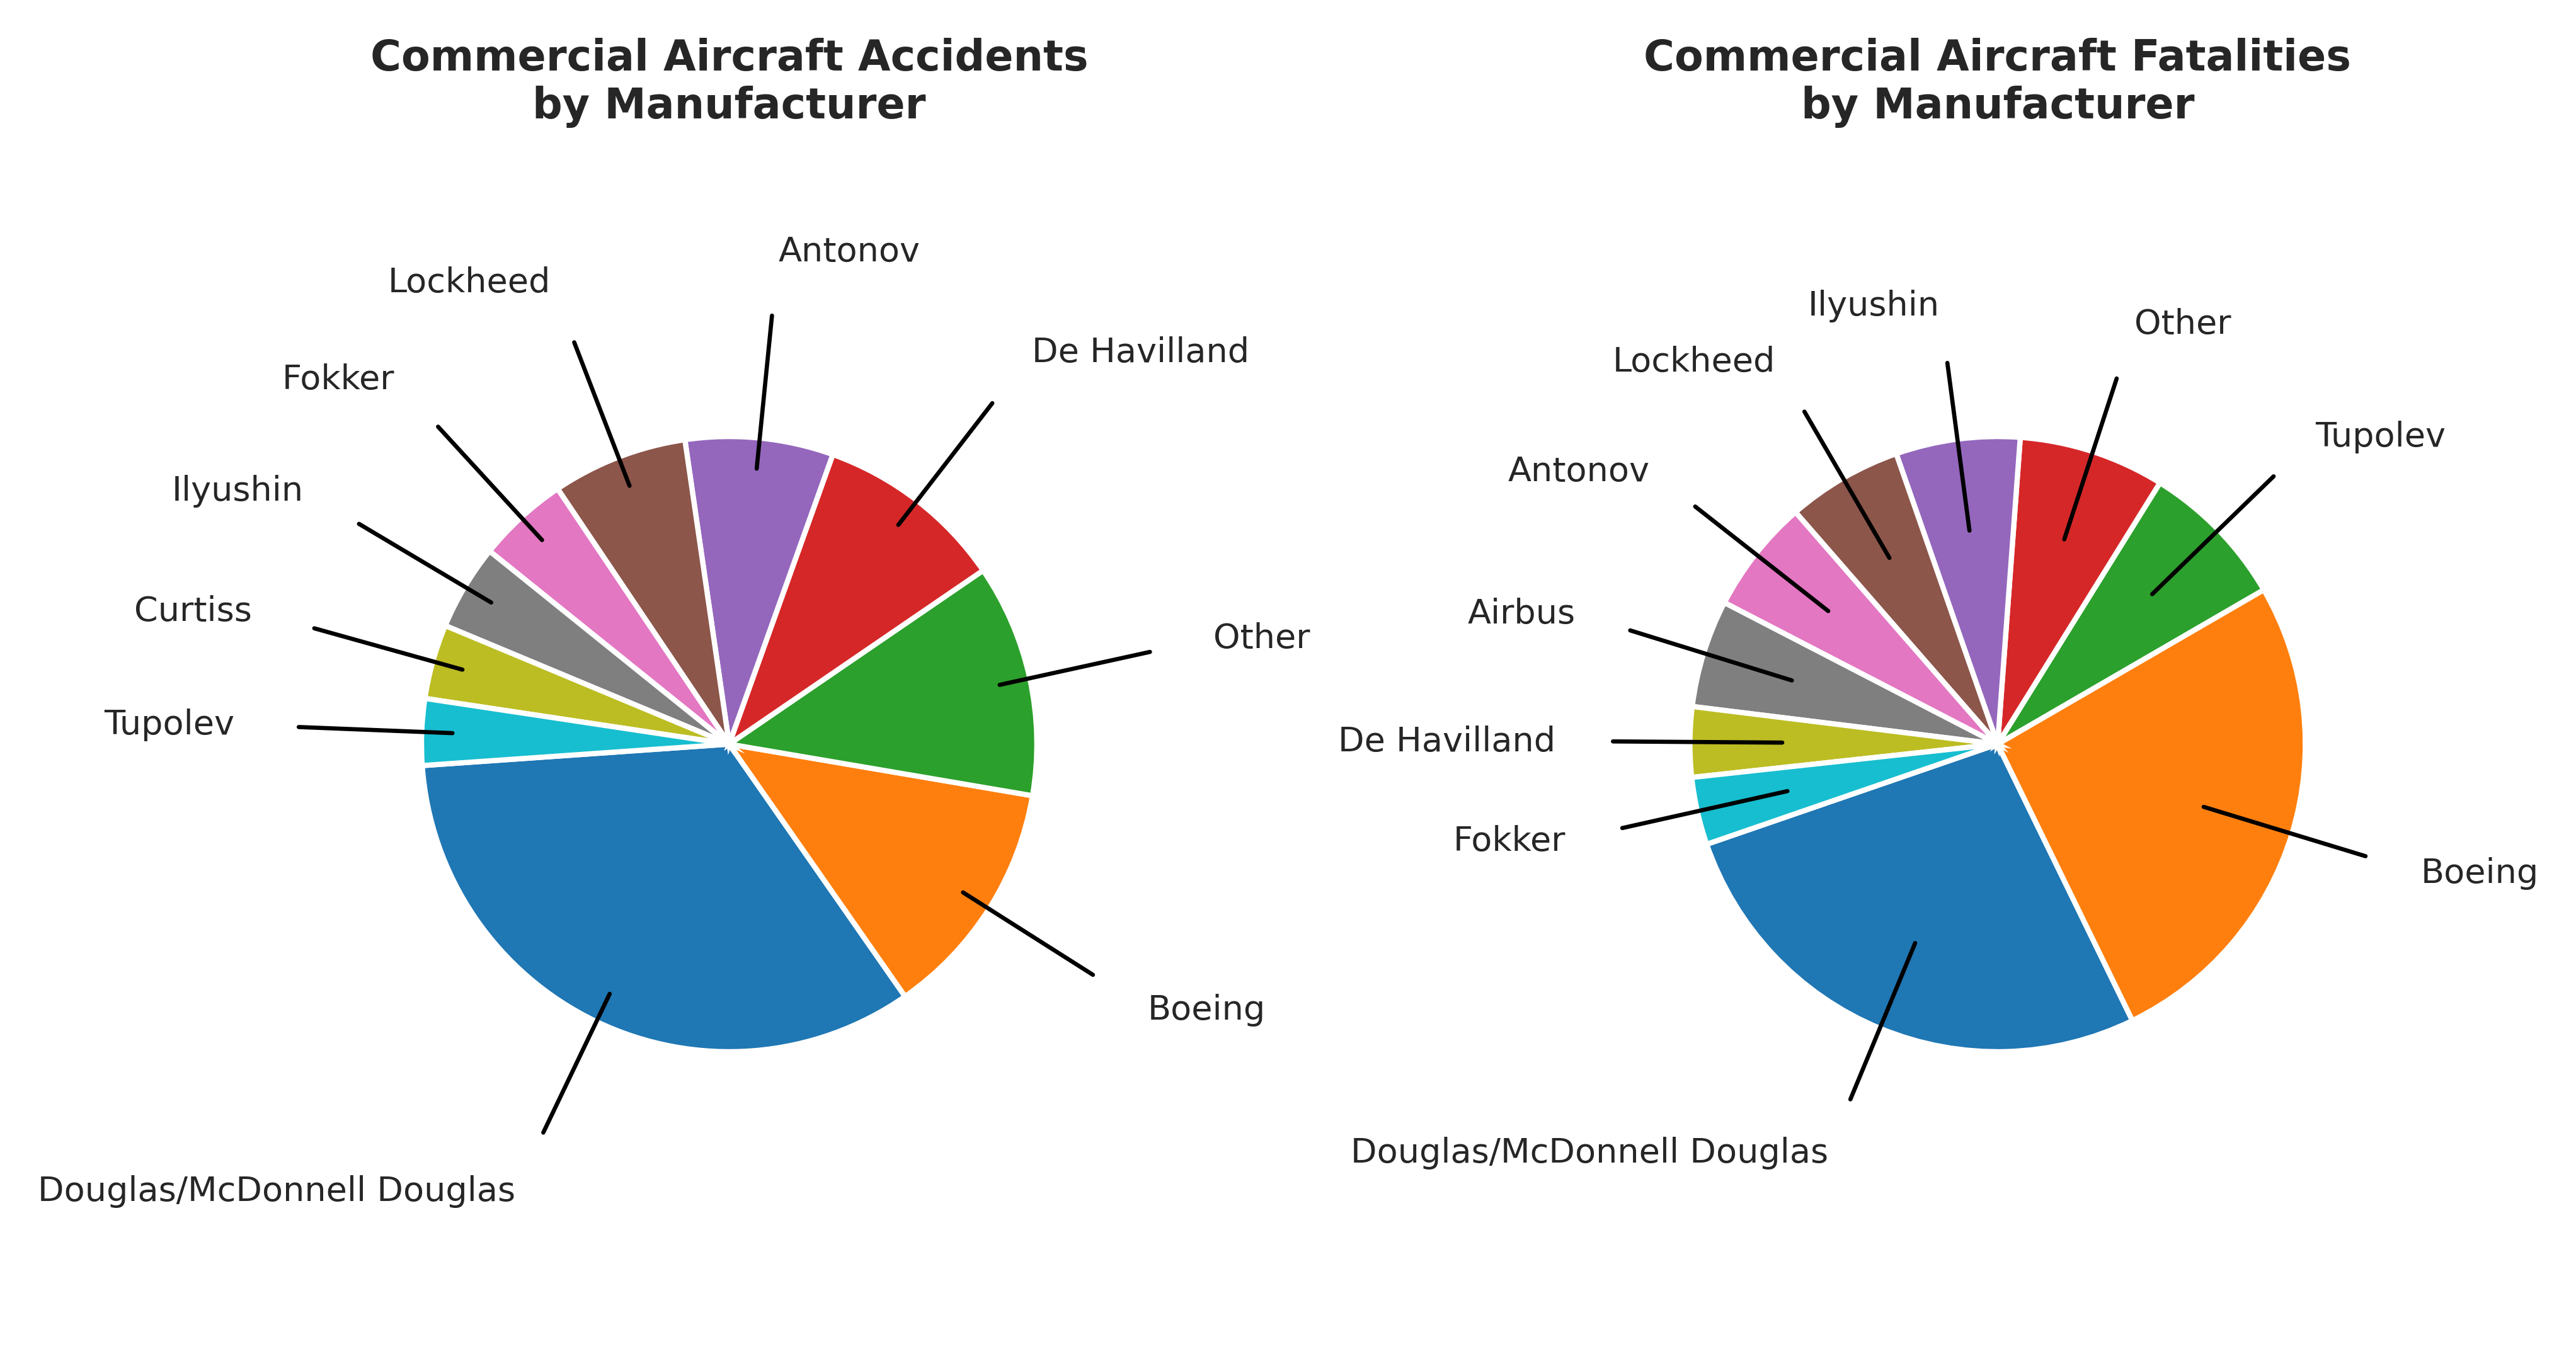

In [37]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8 

commercial_df = air_accident_df[air_accident_df['Operator_Type'] == 'Commercial']
manufacturer_accidents = commercial_df['Manufacturer'].value_counts()

top_n = 10
top_manufacturers = manufacturer_accidents.head(top_n)
other_accidents = manufacturer_accidents.iloc[top_n:].sum()


# Calculate fatalities by manufacturer
fatalities_by_manufacturer = commercial_df.groupby('Manufacturer')['Fatality'].sum()
top_fatalities = fatalities_by_manufacturer.nlargest(top_n)
other_fatalities = fatalities_by_manufacturer.drop(top_fatalities.index).sum()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.7, 3.5), dpi=600, constrained_layout=True)

tab10_colors = plt.cm.tab10(np.linspace(0, 1, 10)).tolist()
colors = tab10_colors + ['#808080']  # Assign gray for "Other" category

# First pie chart: Accidents by Manufacturer
wedges1, texts1 = ax1.pie(
    top_manufacturers.values,
    labels=top_manufacturers.index,
    startangle=184,
    labeldistance=1.4,
    colors=colors[:len(top_manufacturers)],
    textprops={'fontsize': 6, 'weight': 'normal'},
)

for text, wedge in zip(texts1, wedges1):
    angle = (wedge.theta1 + wedge.theta2) / 2
    x = wedge.r * 0.9 * np.cos(np.radians(angle))  # Start inside wedge
    y = wedge.r * 0.9 * np.sin(np.radians(angle))
    lx, ly = text.get_position()
    ax1.annotate(
        '',
        xy=(x, y),
        xytext=(lx, ly),
        arrowprops=dict(arrowstyle='-', color='black', linewidth=0.8, shrinkA=0, shrinkB=0),
    )
    text.set_position((lx * 1.15, ly * 1.15))  # Adjust label position
    text.set_fontsize(6.5)

ax1.set_title('Commercial Aircraft Accidents\nby Manufacturer', fontsize=8, fontweight='bold', pad=8)
ax1.axis('equal')

# Second pie chart: Fatalities by Manufacturer
wedges2, texts2 = ax2.pie(
    top_fatalities.values,
    labels=top_fatalities.index,
    startangle=199,
    labeldistance=1.25,
    colors=colors[:len(top_fatalities)],
    textprops={'fontsize': 6.5, 'weight': 'normal'},
)

for text, wedge in zip(texts2, wedges2):
    angle = (wedge.theta1 + wedge.theta2) / 2
    x = wedge.r * 0.7 * np.cos(np.radians(angle))
    y = wedge.r * 0.7 * np.sin(np.radians(angle))
    lx, ly = text.get_position()
    ax2.annotate(
        '',
        xy=(x, y),
        xytext=(lx, ly),
        arrowprops=dict(arrowstyle='-', color='black', linewidth=0.8, shrinkA=0, shrinkB=0),
    )
    text.set_position((lx * 1.15, ly * 1.15))
    text.set_fontsize(6.5)
ax2.set_title('Commercial Aircraft Fatalities\nby Manufacturer', fontsize=8, fontweight='bold', pad=8)
ax2.axis('equal')

# Main Takeaways from Aircraft Accident Analysis

This analysis of the aircraft accident dataset (1920–2025) reveals critical patterns in aviation safety, with implications for regulation, climate research, and manufacturer accountability. Below are the key findings:

- **Temporal Trends Show Declining Incidents**

- **Seasonal Trends Suggest Climate Impacts, with Fall having the most accidents**

- **Post-1988 Regulations Improved Safety**

- **Geographical Hotspots Highlight High-Risk Regions such as USA, Russia, and Brazil**

- **Boeing and Douglas Leads in Commercial Accidents and Fatalities**

# Implications and Next Steps
This analysis provides a foundation for improving aviation safety and addressing weather related effects.

Next, integrating:
1. historical weather data could confirm climate impacts (e.g., storm-driven crashes)
2. No. of flights per region and year 
